<a href="https://colab.research.google.com/github/Tstrebe2/predicting-text-difficulty/blob/dave-updates/code/dave_Decision_Trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [177]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn. metrics import precision_score, recall_score, precision_recall_curve, roc_auc_score, auc, accuracy_score,f1_score
import graphviz
from sklearn.tree import export_graphviz

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [167]:
filepath='drive/Shareddrives/Milestone 2/'
train = pd.read_csv(f'{filepath}Training_set.csv', 
                      sep='\t',index_col='ix')

test = pd.read_csv(f'{filepath}Testing_set.csv', sep='\t',
                     index_col='ix')

In [11]:
train.head()

,original_text,lemmatized_text,d_chall_score,aoa_mean,aoa_min,aoa_max,conc_rating_mean,conc_rating_min,conc_rating_max,num_lemmas,label
ix,,,,,,,,,,,
0,There is manuscript evidence that Austen conti...,There be manuscript evidence that Austen conti...,8.817221,5.809310,3.57,12.12,2.495517,1.33,4.57,39.0,1
1,"In a remarkable comparative analysis , Mandaea...","In a remarkable comparative analysis , Mandaea...",12.320171,7.402308,2.89,11.94,2.334286,1.46,4.93,21.0,1
2,"Before Persephone was released to Hermes , who...","Before Persephone be release to Hermes , who h...",6.594628,5.231351,2.78,11.17,2.556486,1.43,4.86,42.0,1
3,Cogeneration plants are commonly found in dist...,Cogeneration plant be commonly find in distric...,7.015012,6.742000,3.56,11.53,3.369655,1.52,4.93,32.0,1
4,"Geneva -LRB- , ; , ; , ; ; -RRB- is the second...","Geneva - LRB - , ; , ; , ; ; - RRB - be the se...",9.847729,5.455000,3.69,12.62,2.399333,1.43,4.79,28.0,1


In [7]:
train.label.value_counts()

1    187546
0    187546
Name: label, dtype: int64

In [150]:
metrics_df = {"model_name":[],
              "model_instance":[],
              "train_accuracy": [],
              "train_precision": [],
              "train_recall": [],
              "train_f1": [],
              "train_aucprc":[],
              "train_aucroc": [],
              "test_accuracy":[],
              "test_precision":[],
              "test_f1": [],
              "test_recall":[],
              "test_aucprc":[],
              "test_aucroc": []
              }

In [145]:
def compute_metrics(model,model_name,X_train_data,y_train_data, X_test_data, y_test_data):
    # extract the model's hyperparameters and make that part of the identifier for the model 

    metrics_df['model_name'].append(model_name)
    metrics_df['model_instance'].append(model)
   
    # run train data
    y_pred_train = model.predict(X_train_data)
    acc = accuracy_score(y_train_data, y_pred_train)
    recall = recall_score(y_train_data,y_pred_train)
    precision = precision_score(y_train_data, y_pred_train)
    f1 = f1_score(y_train_data,y_pred_train)
    y_proba_train = model.predict_proba(X_train_data)[:,1]
    prc,rec,thres = precision_recall_curve(y_train_data, y_proba_train)
    auc_prc = auc(rec,prc)
    roc = roc_auc_score(y_train_data, y_proba_train)
   
   
    metrics_df['train_accuracy'].append(acc)
    metrics_df['train_recall'].append(recall)
    metrics_df['train_precision'].append(precision)
    metrics_df['train_f1'].append(f1)
    metrics_df['train_aucprc'].append(auc_prc)
    metrics_df['train_aucroc'].append(roc)


    #run test data
    y_pred = model.predict(X_test_data)
    acc = accuracy_score(y_test_data, y_pred)
    recall = recall_score(y_test_data,y_pred)
    precision = precision_score(y_test_data, y_pred)
    f1 = f1_score(y_test_data,y_pred)
    y_proba = model.predict_proba(X_test_data)[:,1]
    prc,rec,thres = precision_recall_curve(y_test_data, y_proba)
    auc_prc = auc(rec,prc)
    roc = roc_auc_score(y_test_data, y_proba)

    metrics_df['test_accuracy'].append(acc)
    metrics_df['test_recall'].append(recall)
    metrics_df['test_precision'].append(precision)
    metrics_df['test_f1'].append(f1)
    metrics_df['test_aucprc'].append(auc_prc)
    metrics_df['test_aucroc'].append(roc)

# Decision Trees (Text Features Only)

In [14]:
# Take a simple decision_tree classifier
vec = TfidfVectorizer(stop_words='english',
                      ngram_range=(1,3))
X_train_vec = vec.fit_transform(train['lemmatized_text'])




In [29]:
sample_df = train.groupby('label').apply(lambda x: x.sample(20000, random_state=99))
sample_df.label.value_counts()

X_train_samp = sample_df[sample_df.columns[:-1]]
y_train_samp = sample_df.label.values



original_text  \
label ix                                                          
0     256934  The Kofun period is a time in the history of J...   
      302533  The word '' Zanzibar '' probably derives from ...   
      336731  They left the coalition and caused its collaps...   
      336554     Qiu Chuji , Chinese Taoist -LRB- d. 1227 -RRB-   
      413164                Jumada al-awwal -LRB- Jum d I -RRB-   
...                                                         ...   
1     48254   Broons -LRB- , Gallo : Bron -RRB- is a commune...   
      128725  Favre started at the quarterback position for ...   
      98268   Rear Admiral Grace Murray Hopper -LRB- Decembe...   
      91683   Since then we have seen robots finally reach a...   
      77053   Spy Kids is the first film of the Spy Kids tri...   

                                                lemmatized_text  \
label ix                                                          
0     256934  The Kofun period be a time in the history of J...   
      302533  The word '' Zanzibar '' probably derive from t...   
      336731  They leave the coalition and cause it collapse...   
      336554  Qiu Chuji , Chinese Taoist - LRB - d . 1227 - ...   
      413164            Jumada al-awwal - LRB - Jum d I - RRB -   
...                                                         ...   
1     48254   Broons - LRB - , Gallo : Bron - RRB - be a com...   
      128725  Favre start at the quarterback position for th...   
      98268   Rear Admiral Grace Murray Hopper - LRB - Decem...   
      91683   Since then we have see robot finally reach a m...   
      77053   Spy Kids be the first film of the Spy Kids tri...   

              d_chall_score  aoa_mean  aoa_min  aoa_max  conc_rating_mean  \
label ix                                                                    
0     256934       5.487318  4.949286     2.89     7.33          2.294286   
      302533      10.510223  5.146875     3.56    12.00          2.250555   
      336731       7.174366  6.204000     3.98    13.94          2.625000   
      336554      16.186800  0.000000     0.00     0.00               NaN   
      413164      16.137200  0.000000     0.00     0.00               NaN   
...                     ...       ...      ...      ...               ...   
1     48254       11.746084  5.790000     2.89    12.05          2.743333   
      128725       8.052000  5.536154     3.69    10.72          2.407692   
      98268       13.690817  6.900000     4.57     9.70          3.210000   
      91683        5.794262  5.348148     2.89    15.07          2.556429   
      77053        7.722873  5.761818     3.86    10.70          3.168182   

              conc_rating_min  conc_rating_max  num_lemmas  
label ix                                                    
0     256934             1.43             4.82        17.0  
      302533             1.33             4.21        34.0  
      336731             1.43             3.67        12.0  
      336554              NaN              NaN         8.0  
      413164              NaN              NaN         7.0  
...                       ...              ...         ...  
1     48254              1.43             4.76        19.0  
      128725             1.43             4.65        35.0  
      98268              1.46             4.93        24.0  
      91683              1.33             4.93        29.0  
      77053              1.43             4.71        11.0  

[40000 rows x 10 columns]

In [64]:
pipeline = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', DecisionTreeClassifier())
                    ])

parameters = {
    'tfidf__min_df': [20],
    'tfidf__stop_words': ['english'],
    'tfidf__ngram_range': [(1, 3)],
    'clf__criterion': ['gini'],
    'clf__splitter': ['best'],
    'clf__min_samples_leaf': [2,5,10],
    'clf__max_depth': [10, 20, 25, 30, 50,75, 80, 100,200,500]
}


grid_dtc_f1 = GridSearchCV(pipeline, 
                            param_grid=parameters,
                            scoring='f1', 
                            cv=StratifiedKFold(n_splits=10),
                            return_train_score=True,
                            n_jobs=-1).fit(X_train_samp['lemmatized_text'],y_train_samp)
grid_dtc_f1.best_params_

{'clf__criterion': 'gini',
 'clf__max_depth': 500,
 'clf__min_samples_leaf': 10,
 'clf__splitter': 'best',
 'tfidf__min_df': 20,
 'tfidf__ngram_range': (1, 3),
 'tfidf__stop_words': 'english'}

In [74]:
res = pd.DataFrame(grid_dtc_f1.cv_results_)
res[res['rank_test_score'] <=20].T

,9,10,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
mean_fit_time,3.434753,3.303141,4.32898,4.071681,3.84098,5.230428,4.676066,4.291425,5.306684,4.850567,4.444381,5.835257,5.243169,4.722827,7.584095,6.539289,5.664591,9.664611,8.318921,6.877122
std_fit_time,0.038575,0.030202,0.064077,0.042362,0.039681,0.075325,0.057763,0.062705,0.053614,0.071129,0.039637,0.080411,0.042371,0.076154,0.107736,0.086963,0.116379,0.202745,0.120209,0.210921
mean_score_time,0.16247,0.154506,0.152787,0.155965,0.155324,0.151023,0.155737,0.148413,0.15716,0.155526,0.150241,0.15909,0.153565,0.150747,0.155677,0.151726,0.147005,0.15334,0.151666,0.140494
std_score_time,0.007459,0.008223,0.010325,0.008751,0.005734,0.004744,0.013962,0.006365,0.008856,0.004609,0.005033,0.006208,0.01026,0.009463,0.005161,0.00491,0.006138,0.007042,0.008262,0.018436
param_clf__criterion,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini,gini
param_clf__max_depth,30,30,50,50,50,75,75,75,80,80,80,100,100,100,200,200,200,500,500,500
param_clf__min_samples_leaf,2,5,2,5,10,2,5,10,2,5,10,2,5,10,2,5,10,2,5,10
param_clf__splitter,best,best,best,best,best,best,best,best,best,best,best,best,best,best,best,best,best,best,best,best
param_tfidf__min_df,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
param_tfidf__ngram_range,"(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)"


In [ ]:
# Higher Max_depth improved training performance but overfit the training data too much.  
# Going to a max_depth of 10 seemed to create parity between test and training, though 
# it's overall poor performance

In [ ]:
Mads Features + tfidf

In [77]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [79]:
num_cols = ['d_chall_score','aoa_mean','aoa_min','aoa_max','conc_rating_mean','conc_rating_min', 'conc_rating_max','num_lemmas']

# TFIDF + Mads Features

In [84]:
from sklearn.pipeline import FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import KBinsDiscretizer




vectorizer = Pipeline([
              ('tfidf', TfidfVectorizer())])

mads_pipe = Pipeline([
              ('impute_mean',SimpleImputer(strategy='mean')),
              ('scaler',MinMaxScaler()),
              ('bin',KBinsDiscretizer(n_bins=4))
              ])

preprocessor = ColumnTransformer(transformers=[
    ('mads',mads_pipe,num_cols),
    ('text', vectorizer, 'lemmatized_text')
    ])


              
pipeline = Pipeline([('preprocessor', preprocessor),
                     ('clf', DecisionTreeClassifier()) # classifier
                     ])

In [108]:
tfidf_prefix = 'preprocessor__text__tfidf__'
clf_prefix = 'clf__'

parameters = {
    tfidf_prefix + 'min_df': [20],
    tfidf_prefix + 'stop_words': ['english'],
    tfidf_prefix + 'ngram_range' : [(1, 3)],
    'clf__criterion': ['gini'],
    'clf__splitter': ['best'],
    'clf__min_samples_leaf': [1,5,10],
    'clf__max_depth': [4,5,6]
}

grid_dtc_all_f1= (GridSearchCV(pipeline,
                                  param_grid=parameters,
                                  scoring='f1',
                                  n_jobs=-1,
                                  cv=StratifiedKFold(n_splits=10),
                                  return_train_score=True
                                  )).fit(X_train_samp,y_train_samp)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


In [109]:
all_features_results = pd.DataFrame(grid_dtc_all_f1.cv_results_)

In [110]:
all_features_results.T

,0,1,2,3,4,5,6,7,8
mean_fit_time,2.371839,2.350779,2.359638,2.423544,2.402359,2.426115,2.459617,2.491002,2.369948
std_fit_time,0.053608,0.044062,0.026273,0.047639,0.044157,0.045131,0.039699,0.130549,0.184085
mean_score_time,0.161711,0.161918,0.168473,0.168616,0.171687,0.172808,0.170681,0.16372,0.158913
std_score_time,0.007934,0.005262,0.011711,0.004058,0.005594,0.00634,0.009973,0.004087,0.020166
param_clf__criterion,gini,gini,gini,gini,gini,gini,gini,gini,gini
param_clf__max_depth,4,4,4,5,5,5,6,6,6
param_clf__min_samples_leaf,1,5,10,1,5,10,1,5,10
param_clf__splitter,best,best,best,best,best,best,best,best,best
param_preprocessor__text__tfidf__min_df,20,20,20,20,20,20,20,20,20
param_preprocessor__text__tfidf__ngram_range,"(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)","(1, 3)"


In [118]:
grid_dtc_all_f1.best_params_

{'clf__criterion': 'gini',
 'clf__max_depth': 5,
 'clf__min_samples_leaf': 1,
 'clf__splitter': 'best',
 'preprocessor__text__tfidf__min_df': 20,
 'preprocessor__text__tfidf__ngram_range': (1, 3),
 'preprocessor__text__tfidf__stop_words': 'english'}

In [130]:


tfidf_best_params = {k[len(tfidf_prefix):]:v 
                     for (k, v) in grid_dtc_all_f1.best_params_.items() 
                     if tfidf_prefix in k}

clf_best_params = {k[len(clf_prefix):]:v 
                   for (k, v) in grid_dtc_all_f1.best_params_.items() 
                   if clf_prefix in k}

num_pipe = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('binner', KBinsDiscretizer(n_bins=4)),
])

text_pipe = Pipeline([
    ('tfidf', TfidfVectorizer(**tfidf_best_params)),
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('text', text_pipe, 'lemmatized_text'),
])

clf = Pipeline([
    ('preprocessor', preprocessor),
    ('clf', DecisionTreeClassifier(**clf_best_params)),
])

In [123]:
X_train, X_val, y_train, y_val = train_test_split(train[num_cols + ['lemmatized_text']], 
                                                  train['label'],
                                                  stratify=train['label'], 
                                                  random_state=99)

In [132]:
clf = clf.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_discretization.py:233: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 5 are removed. Consider decreasing the number of bins.
  "decreasing the number of bins." % jj


In [136]:
model_name = "decision tree"
for k,v in grid_dtc_all_f1.best_params_.items():
  model_name +=f' {v}'

In [151]:

compute_metrics(clf,model_name,X_train,y_train, X_val, y_val)

In [154]:
pd.DataFrame(metrics_df).T

,0
model_name,"decision tree gini 5 1 best 20 (1, 3) english"
model_instance,"(ColumnTransformer(transformers=[('num',\n ..."
train_accuracy,0.644951
train_precision,0.61973
train_recall,0.750268
train_f1,0.67878
train_aucprc,0.71947
train_aucroc,0.67934
test_accuracy,0.640046
test_precision,0.616063


In [164]:
# Extract the feature names from the vectorizer and combine with the numeric (mads) features

text_features_trf = (clf['preprocessor']
                 .transformers_[1][1]
                 ['tfidf']
                 .get_feature_names_out())


num_features_trf = (clf['preprocessor']
                    .transformers_[0][1]
                    ['binner']
                    .get_feature_names_out(num_cols))


all_features_trf = list(num_features_trf) + list(text_features_trf)

In [185]:
# Generate the image and save off in our shared drive

dot_data = tree.export_graphviz(clf['clf'],
                                feature_names=all_features_trf,
                                filled=True)
graph = graphviz.Source(dot_data)
graph.render(filename='decision_tree.gv',
             directory=filepath,
             format='png'
             )

'drive/Shareddrives/Milestone 2/decision_tree.gv.png'

In [232]:
import matplotlib.pyplot as plt
import seaborn as sns


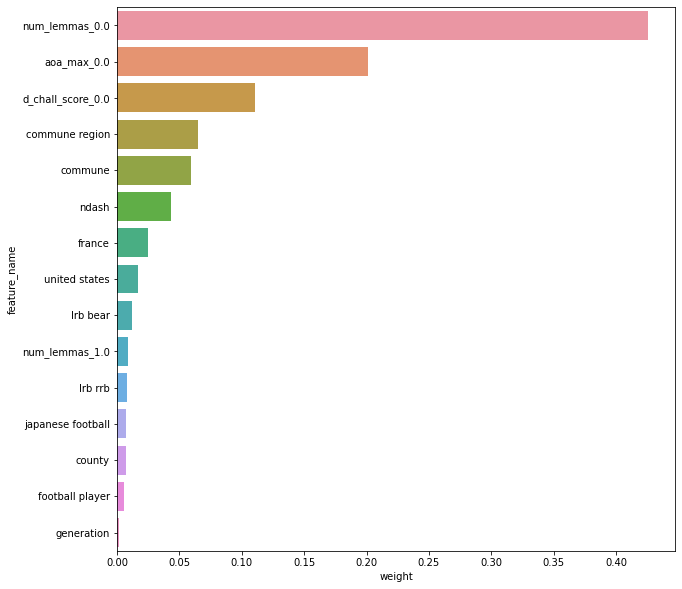

In [235]:
feat_names =  all_features_trf

features_sorted = np.argsort(clf['clf'].feature_importances_)[::-1]
test = list(zip(np.take(all_features_trf,features_sorted)[:15],
                np.take(clf['clf'].feature_importances_,features_sorted)))

data = pd.DataFrame(test, columns=['feature_name','weight'])


plt.figure(figsize=(10,10))
sns.barplot(data=data,
            x='weight',
            y='feature_name',
            orient='h')
